In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
import seaborn as sns

In [5]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize': 22,
          'axes.labelsize': 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [6]:
dataset = pd.read_csv('virus_data.csv')

Id1 = 90
Id2 = 73
random_state = Id1 + Id2
train, test = train_test_split(dataset, test_size = 0.2, random_state = random_state)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def prepare_data(training_data, new_data):
    my_data = new_data.copy()

    PCR3_median = training_data['PCR_03'].median()
    my_data['PCR_03'] = my_data['PCR_03'].fillna(PCR3_median)

    all_features = training_data.columns.tolist() 
    pcr_features = [feature for feature in all_features if feature.startswith("PCR")]

    list_to_standard_scale = [feature for feature in pcr_features 
                          if int(feature.split("_")[1]) in [3, 4, 5, 6, 7, 9, 10]]

    list_to_min_max = [feature for feature in pcr_features 
                   if int(feature.split("_")[1]) in [1, 2, 8]]
    
    features_to_standard_scale = my_data[list_to_standard_scale]
    features_to_min_max = my_data[list_to_min_max]
    
    
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

    standard_scaler.fit(training_data[list_to_standard_scale])
    minmax_scaler.fit(training_data[list_to_min_max])
    

    standard_scaled_features = pd.DataFrame(standard_scaler.transform(features_to_standard_scale),
                                           columns=list_to_standard_scale,
                                           index=my_data.index)
    min_max_scaled_features = pd.DataFrame(minmax_scaler.transform(features_to_min_max),
                                           columns=list_to_min_max,
                                           index=my_data.index)
    
    my_data[list_to_standard_scale] = standard_scaled_features
    my_data[list_to_min_max] = min_max_scaled_features

    return my_data

In [8]:
train_df = prepare_data(train, train)
test_df = prepare_data(train, test)
X_train_df = train_df.drop(columns = ["contamination_level"])
y_train_df = train_df["contamination_level"]
X_test_df = test_df.drop(columns = ["contamination_level"])
y_test_df = test_df["contamination_level"]

In [9]:
dataset.columns

Index(['patient_id', 'age', 'weight', 'happiness_score', 'sugar_levels',
       'PCR_03', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07',
       'PCR_08', 'PCR_09', 'PCR_10', 'contamination_level'],
      dtype='object')

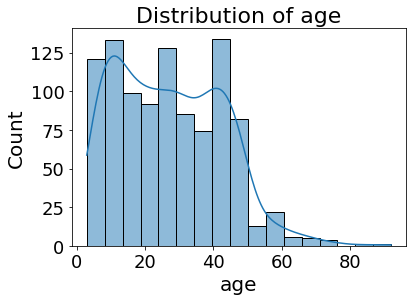

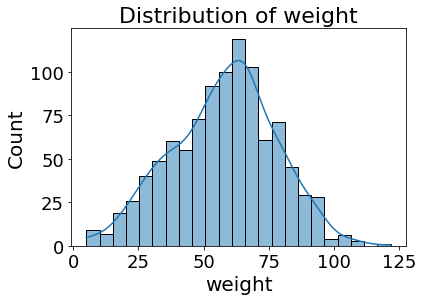

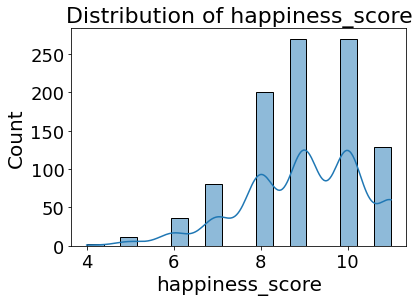

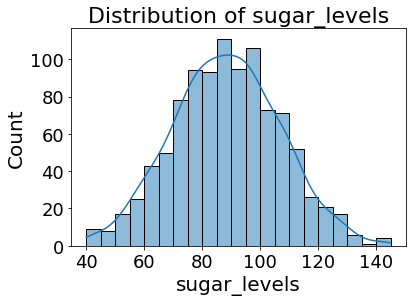

In [10]:
X_train_df = X_train_df.drop(columns = ["patient_id"])
X_test_df = X_test_df.drop(columns = ["patient_id"])


# chack which normalize method to use by the feature behaviour 
features = ['age', 'weight', 'happiness_score', 'sugar_levels']
for feature in features:
    plt.figure()
    sns.histplot(X_train_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [11]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

standard_features = ['weight', 'happiness_score', 'sugar_levels']
minmax_features = ['age']

standard_scaler.fit(X_train_df[standard_features])
X_train_df[standard_features] = standard_scaler.transform(X_train_df[standard_features])
X_test_df[standard_features] = standard_scaler.transform(X_test_df[standard_features])

minmax_scaler.fit(X_train_df[minmax_features])
X_train_df[minmax_features] = minmax_scaler.transform(X_train_df[minmax_features])
X_test_df[minmax_features] = minmax_scaler.transform(X_test_df[minmax_features])

In [12]:
X_train_part1, X_val_part1, y_train_part1, y_val_part1 = train_test_split(X_train_df, y_train_df, test_size = 0.2, random_state = random_state)

In [13]:
from sklearn.base import BaseEstimator, RegressorMixin

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        
        loss = np.mean((X @ w + b - y)**2)

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        m = len(y)
        g_w = 2/m * X.T @ (X @ w + b - y)
        g_b = 2/m * np.sum(X @ w + b - y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w,self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b 

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X @ self.w + self.b

        return y_pred

In [14]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


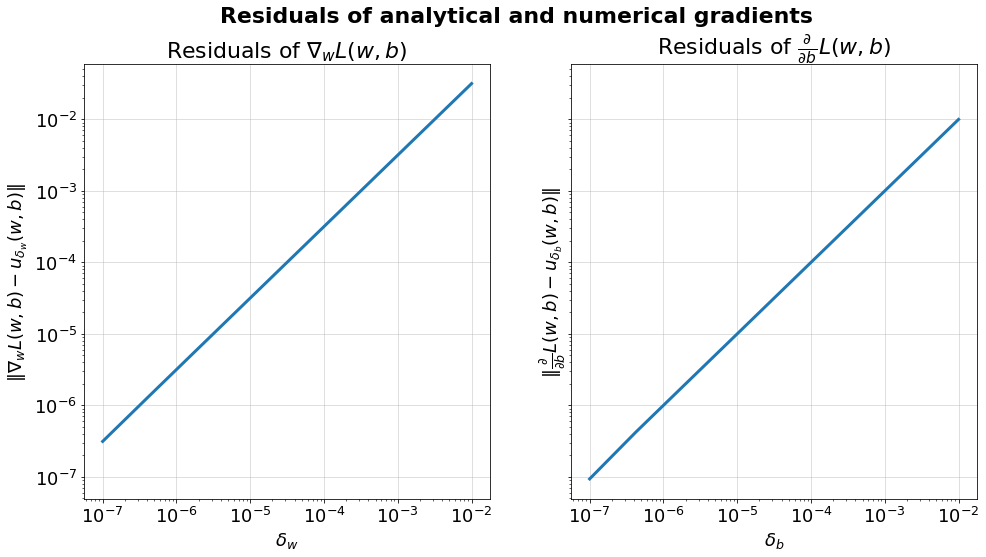

In [15]:
compare_gradients(X_train_part1, y_train_part1, deltas=np.logspace(-7,-2,9))

In [16]:
def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.14635390283498148, Best validation loss = 0.14283096131141557
lr size = 1e-08, Best train loss = 0.14634625970322213, Best validation loss = 0.14282349493261404
lr size = 1e-07, Best train loss = 0.14626985564975306, Best validation loss = 0.14274885796099088
lr size = 1e-06, Best train loss = 0.14550853495664426, Best validation loss = 0.14200516343068187
lr size = 1e-05, Best train loss = 0.13816085917027965, Best validation loss = 0.13482939868649887
lr size = 0.0001, Best train loss = 0.085809348789058, Best validation loss = 0.08385494510880173
lr size = 0.001, Best train loss = 0.027402181632404456, Best validation loss = 0.029578301224533796
lr size = 0.01, Best train loss = 0.026434420654580394, Best validation loss = 0.02885683615283626
lr size = 0.1, Best train loss = 0.026675232721997285, Best validation loss = 0.02848626901039024


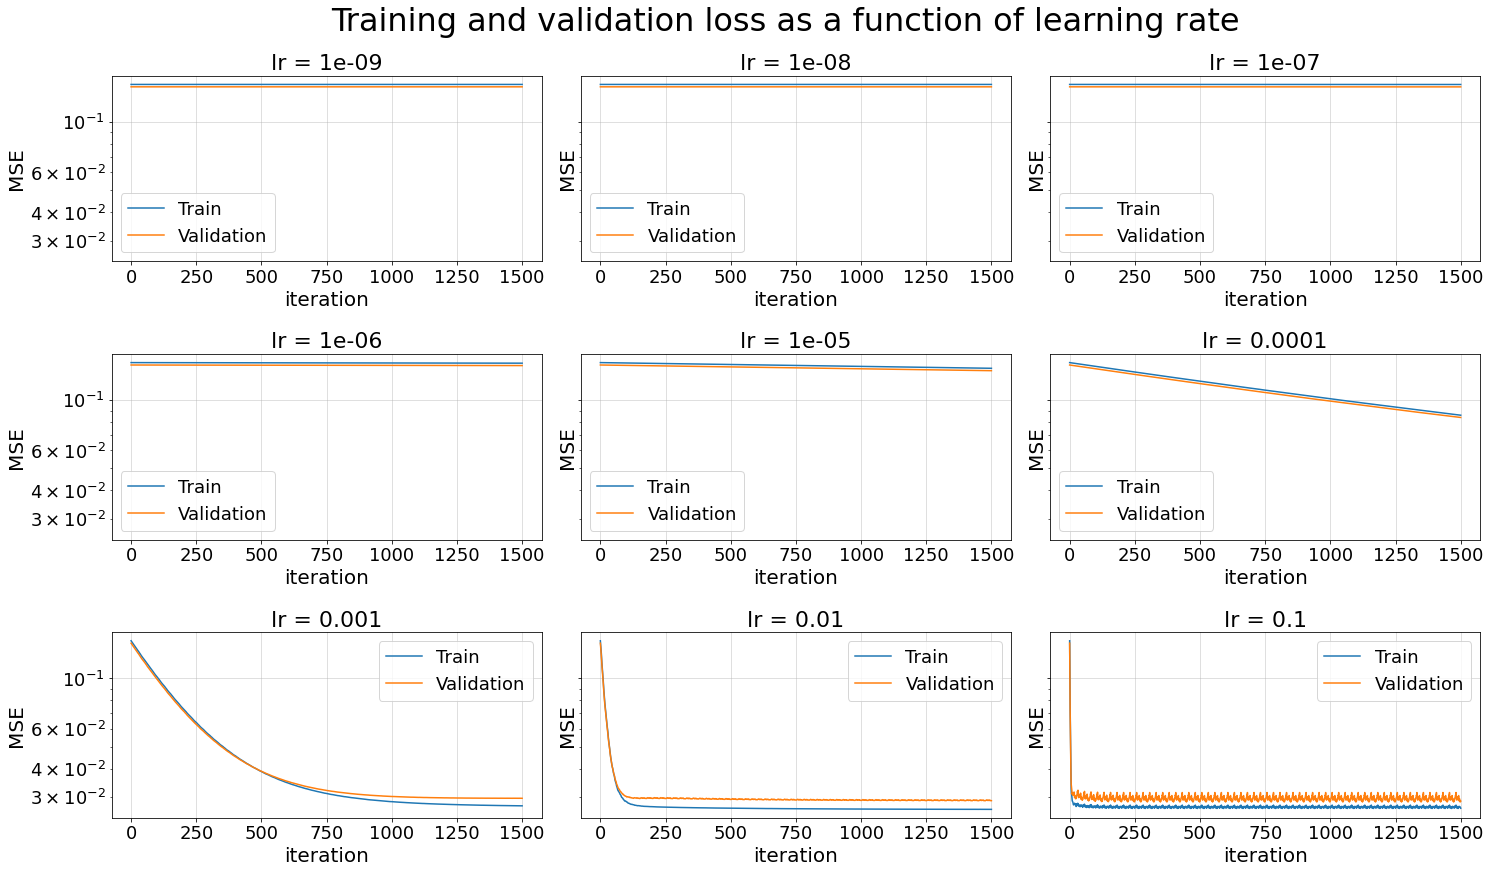

In [17]:
test_lr(X_train_part1, y_train_part1, X_val_part1, y_val_part1, title = "Training and validation loss as a function of learning rate")

In [18]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import  cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

dummy = DummyRegressor(strategy="mean")

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(
    dummy,
    X_train_df,
    y_train_df,
    cv=5,
    scoring={"mse": mse_scorer},
    return_train_score=True
)

train_mse = -cv_results["train_mse"].mean()
valid_mse = -cv_results["test_mse"].mean()

print(f"Train MSE: {train_mse:.4f}")
print(f"Valid MSE: {valid_mse:.4f}")


Train MSE: 0.0442
Valid MSE: 0.0444


In [19]:

#Instantiate and fit on full train split
dummy_final = DummyRegressor(strategy="mean")
dummy_final.fit(X_train_df, y_train_df)


DummyRegressor()

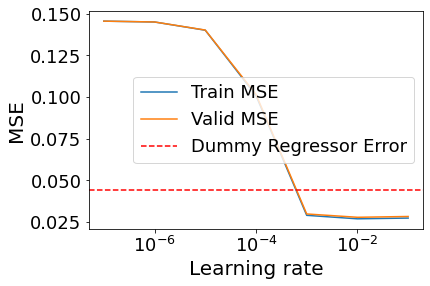

Best learning rate: lr = 1.0e-02
Validation MSE at this lr: 0.0278


In [23]:

lr_list = np.logspace(-7, -1, num=7)

train_mses, valid_mses = [], []

for lr in lr_list:
    linear_regressor = LinearRegressor(lr)
    cv = cross_validate(
        linear_regressor,
        X_train_df, y_train_df,
        cv=5,
        scoring="neg_mean_squared_error",
        return_train_score=True,
        n_jobs = -1
    )
    train_mses.append(-cv["train_score"].mean())
    valid_mses.append(-cv["test_score"].mean())
    

dummy = DummyRegressor(strategy="mean")
dummy_res = cross_validate(dummy, X_train_df, y_train_df, cv=5,
                           scoring="neg_mean_squared_error",
                           n_jobs=-1)
dummy_mse = -dummy_res["test_score"].mean()

plt.semilogx(lr_list, train_mses, label="Train MSE")
plt.semilogx(lr_list, valid_mses, label="Valid MSE")
plt.axhline(y=dummy_mse, color='r', linestyle='--', label='Dummy Regressor Error')
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.legend()
plt.show()

best_idx = np.argmin(valid_mses)
best_lr  = lr_list[best_idx]
best_mse = valid_mses[best_idx]
print(f"Best learning rate: lr = {best_lr:.1e}")
print(f"Validation MSE at this lr: {best_mse:.4f}")

In [ ]:
linear_regressor = LinearRegressor(best_lr)
linear_regressor.fit(X_train_df, y_train_df)